# Analyze Lisflood results stored in a NetCDF file

In this notebook we do some analysis of LISFLOOD results, stored in a NetCDF file. If you run run_wflow_lisflood, you should get a one-year netcdf file as result that you can use here.

In [1]:
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as img_tiles

import xarray as xr
import fiona
import sys, os
import hvplot.xarray
import matplotlib.pyplot as plt
# add the path to our own utils
sys.path.append("/home/hcwinsemius/git/barotse/utils")
import utils


Now let's see if there's data in our dataset NetCDF file. We expect stuff like H, Qx and Qy for depth, flow in x and y-direction

In [2]:
# PASTE THE PATH TO YOUR RESULTS FILE BELOW
fn = '/home/hcwinsemius/Barotse/Barotse_500m_MERIT/test.nc'
ds = xr.open_dataset(fn)
print(ds)

<xarray.Dataset>
Dimensions:  (time: 365, x: 347, y: 584)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-02 2000-01-03 ... 2000-12-31
  * y        (y) float64 8.454e+06 8.454e+06 8.453e+06 ... 8.163e+06 8.163e+06
  * x        (x) float64 6.752e+05 6.758e+05 6.762e+05 ... 8.478e+05 8.482e+05
Data variables:
    SGCQin   (time, y, x) float64 ...
    H        (time, y, x) float64 ...
    Qx       (time, y, x) float64 ...
    Qy       (time, y, x) float64 ...


With hvplot we can make a simple animation to screen results

In [3]:
%matplotlib inline
ds['H'].hvplot.quadmesh('x', 'y', cmap='viridis', rasterize=True, dynamic=True, frame_width=200, datashade=True)


:DynamicMap   [time]
   :RGB   [x,y]   (R,G,B,A)

We have made our own little function to plot discharges through cross-sections from a geopackage, shapefile or other geographical info file. Let's bring that up and plot the cross sections first

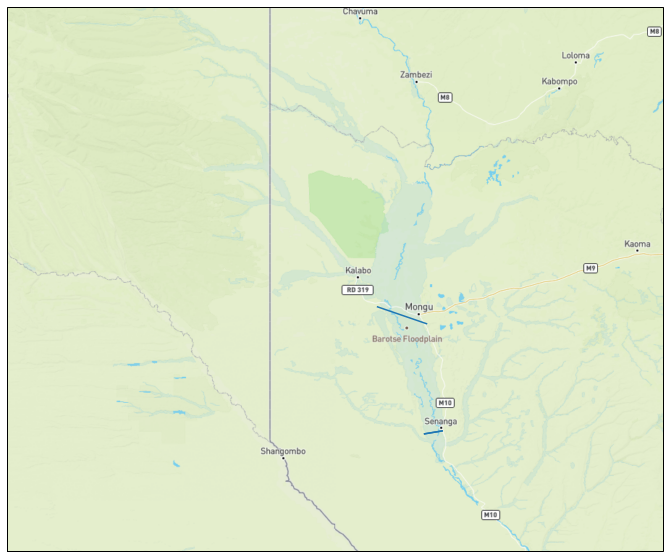

In [4]:

from matplotlib.collections import LineCollection
from shapely.geometry import shape
token = 'pk.eyJ1IjoiaGN3aW5zZW1pdXMiLCJhIjoiY2l2MHd3aDN4MDA0OTJ6dDU2Y2F6MWk0dCJ9.mLH0b46r4cHNdb1w9-dLcQ'
outdoor = img_tiles.MapboxStyleTiles(token, 'hcwinsemius', 'ck4ohy7u59mfg1cmi0z2twtll')
f = plt.figure(figsize=(18, 10))
ax = plt.subplot(111, projection=outdoor.crs)
ax.set_extent([20, 25, -17, -13], crs=ccrs.PlateCarree())
ax.add_image(outdoor, 8, interpolation='bilinear')
# a
# # PASTE THE PATH TO THE CROSS SECTIONS BELOW
cross_file = r'../gis/cross_sections.gpkg'
feats = fiona.open(cross_file)
lines = []
for idx, p in enumerate(feats):
#     p = shape(p['geometry'])
    lines.append(shape(p['geometry'])) #, fc='k', ec='#555555', alpha=1., zorder=1))
    ax.add_collection(LineCollection(lines, transform=ccrs.UTM(34, southern_hemisphere=True)))


Compute flows with our own little utils library and estimate mean flow over entire simulation period

In [5]:
Q = utils.discharge(ds['Qx'], ds['Qy'], feats, key='name')
print(Q.mean(dim='time'))

<xarray.DataArray (station: 2)>
array([3179.81621537, 3750.92929764])
Coordinates:
  * station  (station) object 'senanga' 'mongu'


So the mean flow over the entire year at senanga (downstream) is 3180 m3/s and 3750 at Mongu (upstream). Probably a lot of water is stored (simulated, not in reality) and left behind on the floodplain in this first simulation year. Now plot the results in lines!

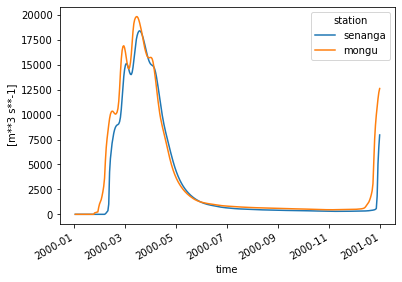

In [6]:
Q.plot.line(x='time')

We see this in the lines as well. It takes long for the floodplain to fill up and result in flows at Senanga. Finally close the dataset properly!

In [7]:
ds.close()